# Gut Microbiota Status Classification Using TabTransformer

## Step 0: Install Required Libraries

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn shap category_encoders xgboost lightgbm pytorch-tabular rtdl

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached shap-0.47.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached xgboost-3.0.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
  Using cached pytorch_tabular-1.1.1-py2.py3-none-any.whl.metadata (24 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached nvidia_nccl_cu12-2.26.5-py3-no

## Step 1: Load and Explore Dataset

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Separate Columns

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, f_classif, VarianceThreshold
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/asicoltd/dataset_list/refs/heads/main/health_data_10000_chunk.csv")

def split_comma_columns(df, delimiter=','):
    df = df.copy()  # Avoid modifying original
    new_columns = []

    for col in df.columns:
        if df[col].dtype == object and df[col].str.contains(delimiter).any():
            # Find max number of splits (some rows may have more than 1 comma)
            max_splits = df[col].str.count(delimiter).max() + 1

            # Split the column
            split_cols = df[col].str.split(delimiter, expand=True, n=max_splits - 1)

            # Rename new columns
            split_cols.columns = [f"{col}_{i+1}" for i in range(split_cols.shape[1])]
            new_columns.extend(split_cols.columns)

            # Add new columns to df
            df = df.drop(columns=[col])
            df = pd.concat([df, split_cols], axis=1)
    print("New Columns after splitting:")
    for i in range(len(new_columns)):
        print(f"{i+1}: {new_columns[i]}")
    return df

total_nulls = df.isnull().sum().sum()
print('Total Null values:',total_nulls)
print("Before Separating comma based separeted data",df.shape)
df = split_comma_columns(df)
print("After Separating comma based separeted data",df.shape)


Total Null values: 0
Before Separating comma based separeted data (10000, 54)
New Columns after splitting:
1: Medical conditions_1
2: Medical conditions_2
3: Medications in use_1
4: Medications in use_2
5: Residential Address_1
6: Residential Address_2
7: Family history of diseases_1
8: Family history of diseases_2
9: Smoking status (Yes/No, quantity)_1
10: Smoking status (Yes/No, quantity)_2
11: Diagnosed conditions_1
12: Diagnosed conditions_2
13: Relevant family history_1
14: Relevant family history_2
15: Supplement Plan - Recommended products_1
16: Supplement Plan - Recommended products_2
17: Supplement Plan - Dosages and timings_1
18: Supplement Plan - Dosages and timings_2
19: Meal Plan - Recommended/avoided foods_1
20: Meal Plan - Recommended/avoided foods_2
21: Meal Plan - Recommended/avoided foods_3
22: Weekly menu_1
23: Weekly menu_2
24: Weekly menu_3
25: Personalized recipes_1
26: Personalized recipes_2
After Separating comma based separeted data (10000, 68)


Visualization

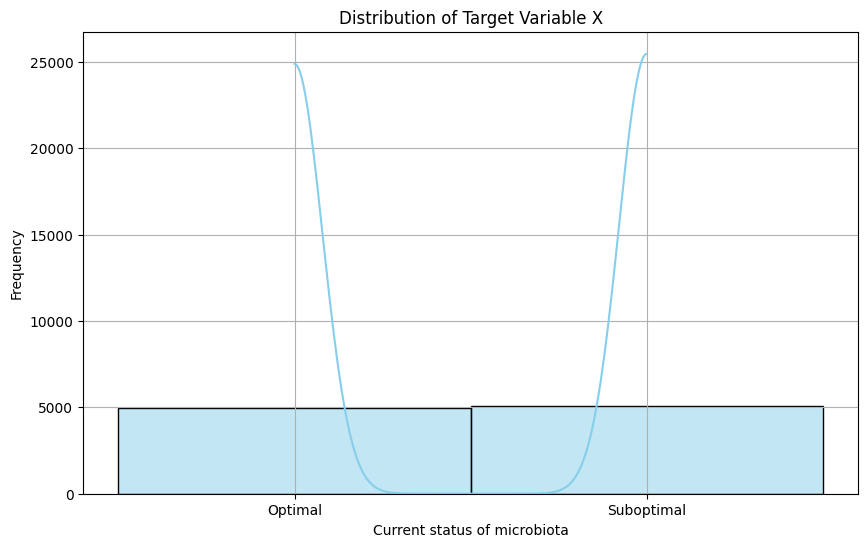

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Current status of microbiota'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Target Variable X')
plt.xlabel('Current status of microbiota')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Current Diet VS BMI

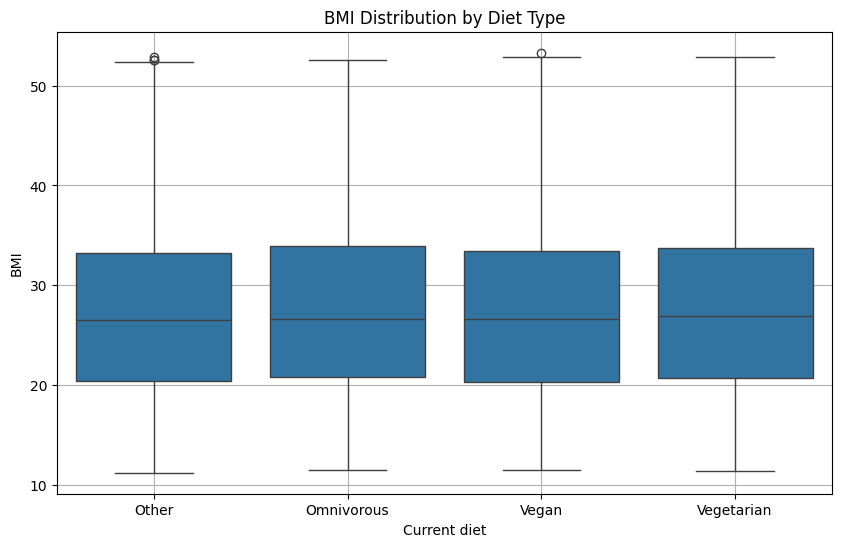

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Current diet', y='BMI')
plt.title('BMI Distribution by Diet Type')
plt.xlabel('Current diet')
plt.ylabel('BMI')
plt.grid(True)
plt.show()


Outliners

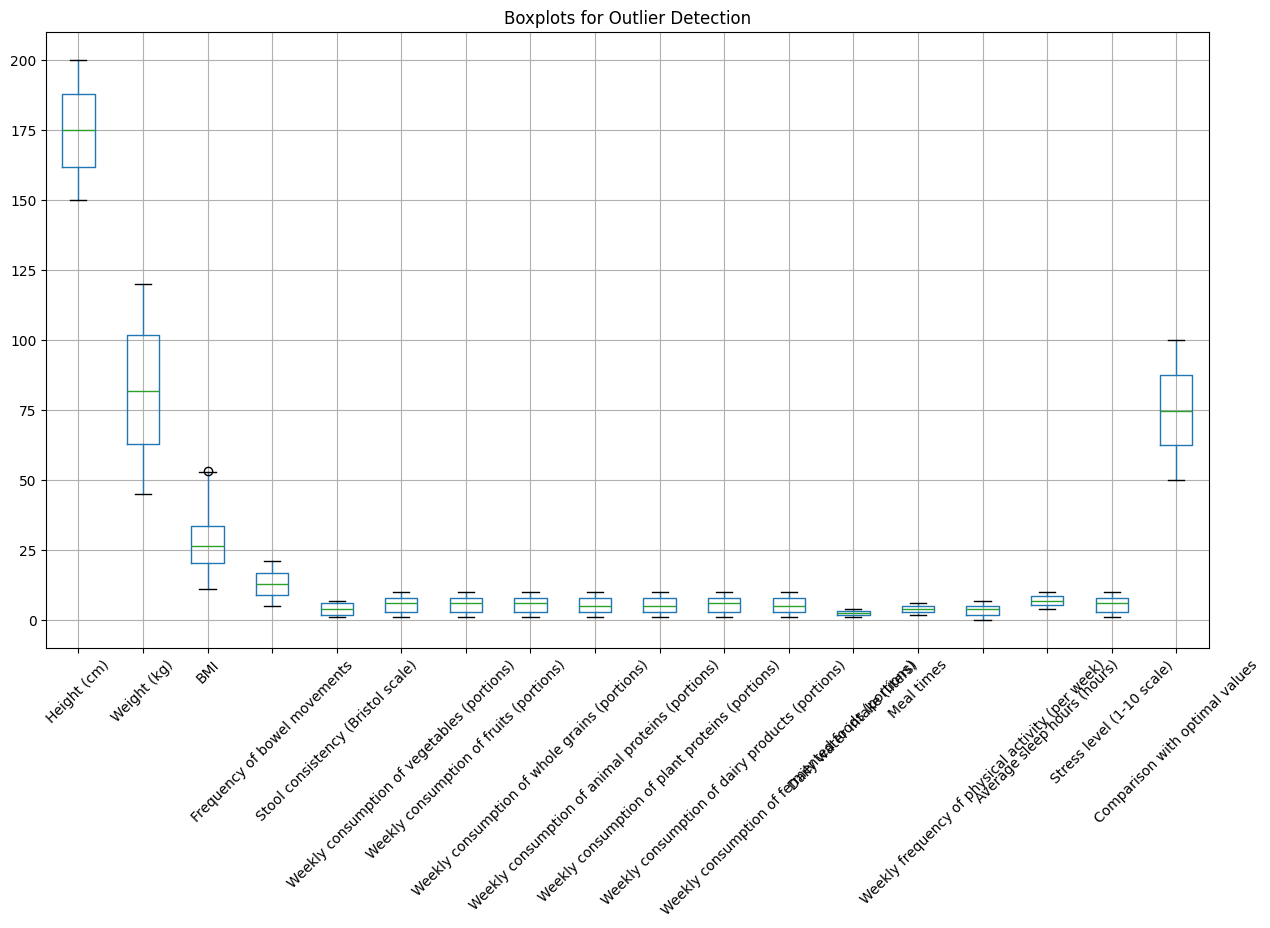

In [7]:
numerical_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(15, 8))
df[numerical_cols].boxplot()
plt.title('Boxplots for Outlier Detection')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


def impute_outliers(data, column, method='median'):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if method == 'mean':
        replacement = data[column].mean()
    else:
        replacement = data[column].median()

    data[column] = np.where((data[column] < lower) | (data[column] > upper),
                            replacement, data[column])
    return data
df = impute_outliers(df,'BMI')


Checking Corelations with Current status of microbiota column

In [8]:

# Separate features and target
target_col = 'Current status of microbiota'
X = df.drop(columns=[target_col])
y = df[target_col]

# Detect target type
is_classification = y.nunique() < 20 and y.dtype in ['int', 'object', 'category']
print("Detected task type:", "Classification" if is_classification else "Regression")

# Encode categorical target if needed
if is_classification and y.dtype == 'object':
    y = y.astype('category').cat.codes

# Encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Remove constant or low variance features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_encoded)
X_filtered = pd.DataFrame(X_filtered, columns=X_encoded.columns[selector.get_support()])


# -------- Feature Importance with respect to Y --------
if is_classification:
    mi_scores = mutual_info_classif(X_filtered, y)
    f_vals, _ = f_classif(X_filtered, y)
else:
    mi_scores = mutual_info_regression(X_filtered, y)
    f_vals = np.full(X_filtered.shape[1], np.nan)  # Skip F-test for regression

mi_series = pd.Series(mi_scores, index=X_filtered.columns).sort_values(ascending=False)
print("\nTop features by Mutual Information:\n", mi_series.head(15))

if is_classification:
    f_series = pd.Series(f_vals, index=X_filtered.columns).sort_values(ascending=False)
    print("\nTop features by ANOVA F-test:\n", f_series.head(15))

# Align both series to have same index (feature names)
common_features = mi_series.index.intersection(f_series.index)

# Subset and re-align
mi_common = mi_series.loc[common_features]
f_common = f_series.loc[common_features]

# Normalize both scores
mi_norm = (mi_common - mi_common.min()) / (mi_common.max() - mi_common.min())
f_norm = (f_common - f_common.min()) / (f_common.max() - f_common.min())

# Combine via sum of normalized scores or average
combined_score = mi_norm + f_norm
# Sort top features
top_combined = combined_score.sort_values(ascending=False).head(10)
print("Top combined features:\n", top_combined)



Detected task type: Classification

Top features by Mutual Information:
 Meal Plan - Recommended/avoided foods_3_ Chicken     0.013346
Prebiotics                                           0.011106
Personalized recipes_1_Grilled Chicken               0.010785
Meal Plan - Recommended/avoided foods_2_ Broccoli    0.009905
Medications in use_1_Levothyroxine                   0.009470
Medications in use_2_ Lisinopril                     0.009099
Diagnosed conditions_1_Hypertension                  0.008793
Medications in use_2_ Insulin                        0.008451
Smoking status (Yes/No, quantity)_2_ 1               0.008085
Smoking status (Yes/No, quantity)_2_ 6               0.007680
Previous surgeries_Knee surgery                      0.007529
Current diet_Vegetarian                              0.006944
Medical conditions_1_Hypertension                    0.006937
Food allergies_Shellfish                             0.006837
Smoking status (Yes/No, quantity)_1_No               0.0067

In [9]:
def remove_after_underscore(lst):
    return [s.rsplit("_", 1)[0] if isinstance(s, str) else s for s in lst]
top_combined = remove_after_underscore(top_combined.index.tolist())
top_features = top_combined

# Define input X and target y
target_col = "Current status of microbiota"
X = df[top_features]
y = df[target_col]

## Step 2: Preprocessing

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


target_col = "Current status of microbiota"
df[target_col] = LabelEncoder().fit_transform(df[target_col])

X = df.drop(columns=[target_col])
y = df[target_col]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Step 3: Training Models

Logistic Regresion

In [17]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))


/home/asico/Desktop/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       988
           1       0.52      0.53      0.53      1012

    accuracy                           0.52      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.52      0.51      2000



XGB

In [18]:
xgb_model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("=== XGBoost Report ===")
print(classification_report(y_test, y_pred_xgb))


/home/asico/Desktop/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:55:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Report ===
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       988
           1       0.52      0.53      0.52      1012

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



Random Forest

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       988
           1       0.53      0.53      0.53      1012

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [11]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Set your target column
target_col = "Current status of microbiota"
df[target_col] = LabelEncoder().fit_transform(df[target_col])  # e.g., Optimal=1, Suboptimal=0

# Separate features
X = df.drop(columns=[target_col])
y = df[target_col].values

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float', 'int']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode categoricals
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Normalize numerical
X[numerical_cols] = StandardScaler().fit_transform(X[numerical_cols])

# Convert to numpy
X_np = X.values.astype(np.float32)
y_np = y.astype(np.int64)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2, stratify=y_np, random_state=42)


Weight Sampling for imbalance data

In [12]:

from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_val)
y_test_tensor = torch.tensor(y_val)
# Count number of instances per class
class_counts = torch.bincount(y_train_tensor)
class_weights = 1.0 / class_counts.float()

# Assign weights to each sample
sample_weights = class_weights[y_train_tensor]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)


ANN

Epoch 1: Loss = 104.1823
Epoch 2: Loss = 88.5591
Epoch 3: Loss = 73.0751
Epoch 4: Loss = 59.0994
Epoch 5: Loss = 46.8517
Epoch 6: Loss = 37.8953
Epoch 7: Loss = 32.7589
Epoch 8: Loss = 29.1178
Epoch 9: Loss = 29.9684
Epoch 10: Loss = 32.2212
Epoch 11: Loss = 32.1570
Epoch 12: Loss = 31.5235
Epoch 13: Loss = 31.5032
Epoch 14: Loss = 29.5417
Epoch 15: Loss = 27.9763
Epoch 16: Loss = 25.8733
Epoch 17: Loss = 23.6012
Epoch 18: Loss = 21.3724
Epoch 19: Loss = 20.7648
Epoch 20: Loss = 18.6169
=== ANN Classification Report ===
              precision    recall  f1-score   support

  Suboptimal       0.50      0.40      0.44       988
     Optimal       0.51      0.60      0.55      1012

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

AUC-ROC: 0.4945


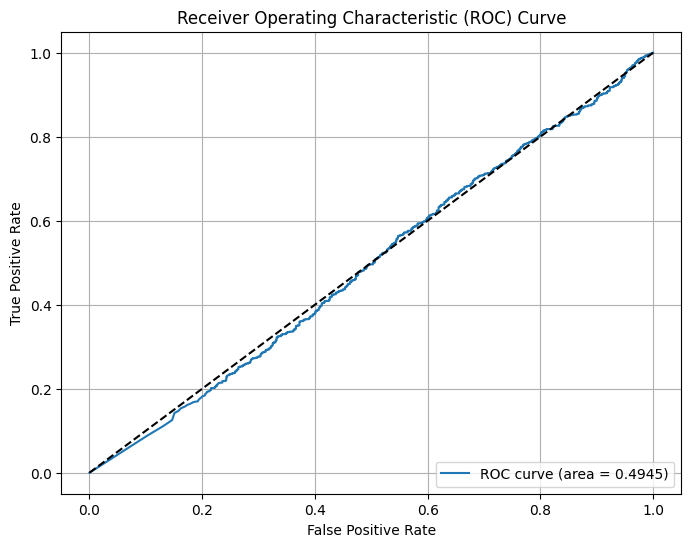

Confusion Matrix:
[[398 590]
 [405 607]]


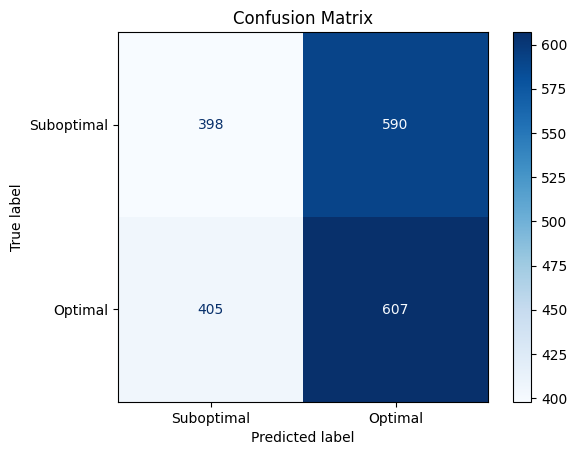

AUC-ROC: 0.4945


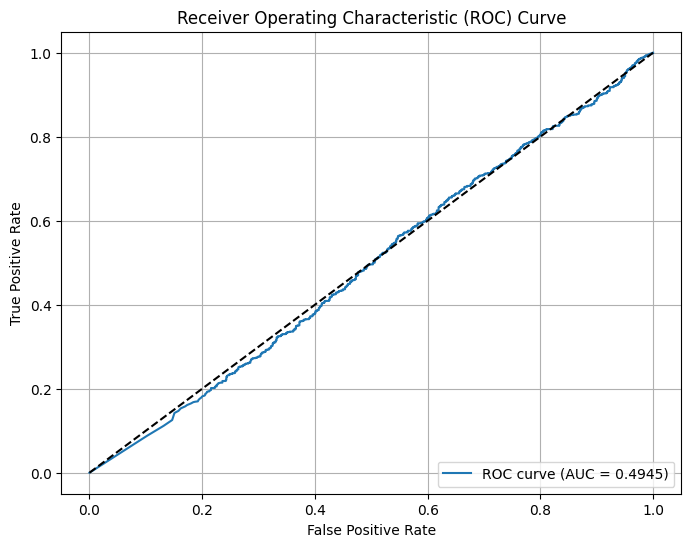

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define a simple ANN
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)  # Output logits for binary classification
        )

    def forward(self, x):
        return self.fc(x)

# Initialize model and device
model = ANNModel(X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
model.train()
for epoch in range(20):
    inputs = X_train_tensor.to(device)
    labels = y_train_tensor.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Evaluation: predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    preds = outputs.argmax(1).cpu().numpy()
    probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

print("=== ANN Classification Report ===")
print(classification_report(y_test, preds, target_names=["Suboptimal", "Optimal"]))


# Calculate AUC score
auc_score = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {auc_score:.4f}")

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion Matrix
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Suboptimal", "Optimal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

auc_score = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


LightGBM

[LightGBM] [Info] Number of positive: 4046, number of negative: 3954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505750 -> initscore=0.023001
[LightGBM] [Info] Start training from score 0.023001
=== LightGBM Report ===
              precision    recall  f1-score   support

  Suboptimal       0.49      0.47      0.48       988
     Optimal       0.50      0.52      0.51      1012

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

AUC-ROC: 0.4972


/home/asico/Desktop/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/asico/Desktop/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


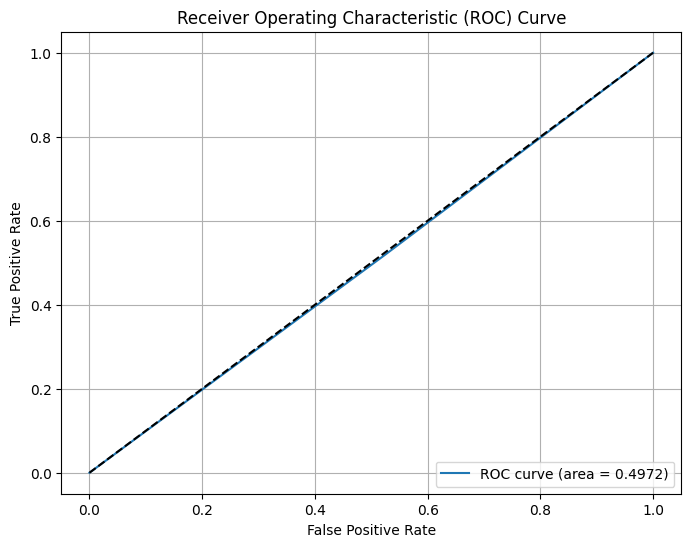

Confusion Matrix:
[[469 519]
 [486 526]]


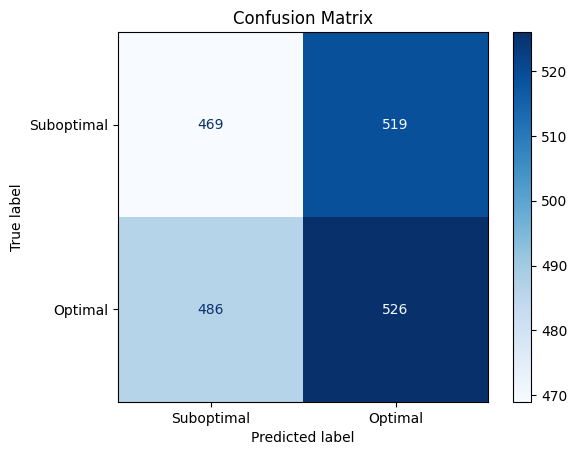

AUC-ROC: 0.4986


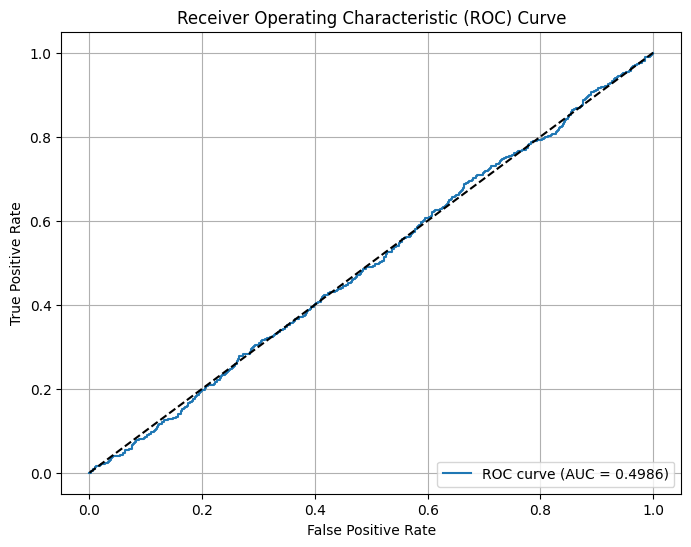

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_val)
y_prob_lgb = lgb_model.predict_proba(X_val)[:, 1]

print("=== LightGBM Report ===")
print(classification_report(y_test, y_pred_lgb, target_names=["Suboptimal", "Optimal"]))

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_lgb)
print(f"AUC-ROC: {auc_score:.4f}")

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgb)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Suboptimal", "Optimal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
auc_score = roc_auc_score(y_test, y_prob_lgb)
print(f"AUC-ROC: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgb)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Tabular Transformer > FT Transformer (Feature Tokenizer + Transformer)

In [ ]:
import rtdl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, roc_auc_score,classification_report,accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.optim as optim
# Create model
model = rtdl.FTTransformer.make_default(
    n_num_features=X.shape[1],
    cat_cardinalities=None,  # encoded all as numeric
    d_out=2,  # binary classification
)

model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop

for epoch in range(10):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(x_num=xb, x_cat=None)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions and labels
        predicted_classes = preds.argmax(dim=1).cpu().numpy()
        all_preds.extend(predicted_classes)
        all_labels.extend(yb.cpu().numpy())

    # Calculate metrics for epoch
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(
        f"Epoch {epoch+1}: "
        f"Accuracy = {acc:.4f}, "
        f"Train Loss = {total_loss:.4f}, "
        f"Precision = {prec:.4f}, "
        f"Recall = {rec:.4f}, "
        f"F1-score = {f1:.4f}"
    )



model.eval()
with torch.no_grad():
    preds = model(x_num=torch.tensor(X_val).to(device), x_cat=None).argmax(1).cpu().numpy()
    probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

print(classification_report(y_val, preds, target_names=["Suboptimal", "Optimal"], zero_division=0))

# Calculate AUC score
auc_score = roc_auc_score(y_test, preds)
print(f"AUC-ROC: {auc_score:.4f}")

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# Confusion Matrix
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Suboptimal", "Optimal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (you already have this but here's the snippet)


auc_score = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Epoch 1: Accuracy = 0.4974, Train Loss = 88.2073, Precision = 0.5037, Recall = 0.5721, F1-score = 0.5357


LSTM Model

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, lstm_layers=1, num_classes=2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim)
        out = lstm_out[:, -1, :]    # take output from the last time step
        return self.fc(out)
# Assume X_train has shape (batch_size, sequence_length, input_dim)
model = LSTMModel(input_dim=X_train.shape[2])  # Input dim = number of features per time step
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
for epoch in range(20):
    inputs = X_train_tensor.to(device)  # Shape: (batch, seq_len, input_dim)
    labels = y_train_tensor.to(device)  # Shape: (batch,)

    optimizer.zero_grad()
    outputs = model(inputs)  # Shape: (batch, num_classes)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/20, Loss: {loss.item():.4f}")

